In [1]:
import os
import sys
from collections import defaultdict
from functools import reduce, partial

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings("ignore")


In [21]:
mt_reads_share = pd.read_csv("../data/share/mapped_reads_stats.tsv", sep="\s\s")
mt_reads_share["mapped_reads"] = mt_reads_share["mapped_reads"].str.removesuffix("%").astype(float)
mt_reads_share.head(2)

,sample,mapped_reads
0,Kgd-mtDNA-S01,5.36
1,Kgd-mtDNA-S02,3.71


In [3]:
path_to_depth = "../data/interim/depth.tsv"
depth = pd.read_csv(path_to_depth, sep="\t")
depth.columns = depth.columns.str.removeprefix("data/interim/mapping/")
print(depth.shape)
depth.head(2)

(16569, 49)


,#CHROM,POS,Kgd-mtDNA-S01.bam,Kgd-mtDNA-S02.bam,Kgd-mtDNA-S03.bam,Kgd-mtDNA-S04.bam,Kgd-mtDNA-S05.bam,Kgd-mtDNA-S06.bam,Kgd-mtDNA-S07.bam,Kgd-mtDNA-S08.bam,...,Kgd-mtDNA-S39.bam,Kgd-mtDNA-S40.bam,Kgd-mtDNA-S41.bam,Kgd-mtDNA-S42.bam,Kgd-mtDNA-S43.bam,Kgd-mtDNA-S44.bam,Kgd-mtDNA-S45.bam,Kgd-mtDNA-S46.bam,Kgd-mtDNA-S47.bam,Kgd-mtDNA-S48.bam
0,NC_012920.1,1,193,64,88,121,288,180,128,190,...,389,650,36,56,83,196,16,59,255,370
1,NC_012920.1,2,194,64,91,119,287,180,135,196,...,399,656,38,59,87,206,16,58,253,371


In [4]:
depth_melted = depth.melt("POS", depth.columns[2:], "Sample", "Depth")
samples_sorted = depth.iloc[:, 2:].mean(axis=0).sort_values().index.values
incorrect_pos = depth.set_index("POS").mean(axis=1).argmin() + 1

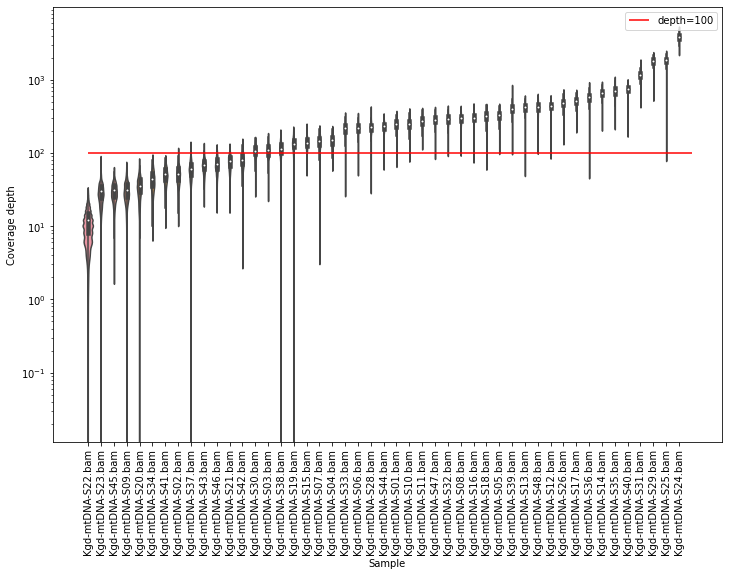

In [5]:
plt.figure(figsize=(12, 8))
sns.violinplot(data=depth_melted[depth_melted.POS != incorrect_pos], y="Depth", x="Sample", order=samples_sorted)
plt.yscale("log")
plt.hlines([100], 0, 47, "r", label="depth=100")
plt.xticks(rotation=90)
plt.ylabel("Coverage depth")
plt.legend()
plt.show()

In [22]:
depth_stats = depth_melted[depth_melted.POS != incorrect_pos].groupby("Sample").Depth.describe().sort_values("mean")
depth_stats.index = depth_stats.index.str.removesuffix(".bam")
depth_stats

,count,mean,std,min,25%,50%,75%,max
Sample,,,,,,,,
Kgd-mtDNA-S22,16568.0,11.861782,5.450964,1.0,8.0,12.0,15.0,32.0
Kgd-mtDNA-S23,16568.0,30.474469,9.715862,0.0,24.0,30.0,36.0,87.0
Kgd-mtDNA-S45,16568.0,31.028911,8.262734,4.0,25.0,31.0,37.0,62.0
Kgd-mtDNA-S09,16568.0,31.784042,9.726244,0.0,25.0,31.0,38.0,72.0
Kgd-mtDNA-S20,16568.0,37.015934,11.549118,1.0,29.0,36.0,44.0,80.0
Kgd-mtDNA-S34,16568.0,45.761649,12.720512,10.0,36.0,44.0,54.0,92.0
Kgd-mtDNA-S41,16568.0,51.397936,12.242562,13.0,43.0,51.0,60.0,90.0
Kgd-mtDNA-S02,16568.0,53.107436,13.801293,14.0,43.0,52.0,62.0,114.0
Kgd-mtDNA-S37,16568.0,61.716985,16.271498,4.0,50.0,60.0,72.0,136.0


In [25]:
(depth_stats["mean"] > 100).sum()

34

In [37]:
34 / 47

0.723404255319149

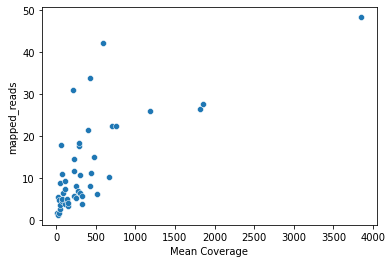

In [29]:
merged = pd.merge(depth_stats, mt_reads_share.set_index("sample"), left_index=True, right_index=True)
sns.scatterplot(data=merged, x="mean", y="mapped_reads")
plt.xlabel("Mean Coverage")
plt.show()

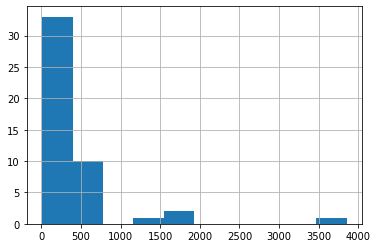

In [31]:
merged["mean"].hist();

<AxesSubplot:>

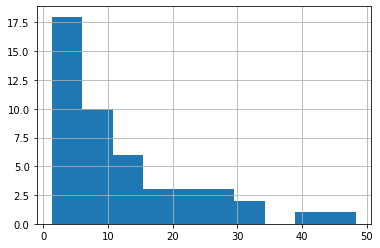

In [32]:
merged["mapped_reads"].hist()

In [36]:
merged

,count,mean,std,min,25%,50%,75%,max,mapped_reads
Kgd-mtDNA-S22,16568.0,11.861782,5.450964,1.0,8.0,12.0,15.0,32.0,1.86
Kgd-mtDNA-S23,16568.0,30.474469,9.715862,0.0,24.0,30.0,36.0,87.0,1.29
Kgd-mtDNA-S45,16568.0,31.028911,8.262734,4.0,25.0,31.0,37.0,62.0,5.55
Kgd-mtDNA-S09,16568.0,31.784042,9.726244,0.0,25.0,31.0,38.0,72.0,1.64
Kgd-mtDNA-S20,16568.0,37.015934,11.549118,1.0,29.0,36.0,44.0,80.0,4.83
Kgd-mtDNA-S34,16568.0,45.761649,12.720512,10.0,36.0,44.0,54.0,92.0,8.88
Kgd-mtDNA-S41,16568.0,51.397936,12.242562,13.0,43.0,51.0,60.0,90.0,2.71
Kgd-mtDNA-S02,16568.0,53.107436,13.801293,14.0,43.0,52.0,62.0,114.0,3.71
Kgd-mtDNA-S37,16568.0,61.716985,16.271498,4.0,50.0,60.0,72.0,136.0,18.01
Kgd-mtDNA-S43,16568.0,70.098322,15.543945,23.0,60.0,69.0,79.0,133.0,11.13


In [35]:
merged.mapped_reads.describe()

count    47.000000
mean     12.389787
std      10.958982
min       1.290000
25%       4.930000
50%       8.090000
75%      17.830000
max      48.350000
Name: mapped_reads, dtype: float64

In [ ]:
fig = px.line(depth_melted[depth_melted.POS != incorrect_pos], x="POS", y="Depth", color='Sample', title="Coverage", height=600, category_orders={"Sample": samples_sorted[::-1]})
fig.show()